In [2]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torchvision import transforms as T
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb
import math

import os
from tqdm.notebook import tnrange, tqdm_notebook
import cv2
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

from scripts import tools
from scripts import custom_transforms as CT

from shapely.geometry import Polygon
from pycocotools import mask as maskUtils
from pycocotools.coco import COCO
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patches as patches
import random

from scripts import tools
from scripts.visualize import BatchVisualizer as bv

In [3]:
root = './Some-Trees-Dataset-11'
os.listdir(root)

['README.dataset.txt', 'test', 'valid', 'README.roboflow.txt', 'train']

In [4]:
class TreeDataset(Dataset):
    def __init__(self, root, subset, image_trans=None, mask_trans=None):
        """
        Args:
            root (str): dataset root path
            subset (str): 'train', 'val', or 'test'
        """
        self.root_dir = os.path.join(root, subset)
        self.ann_file = os.path.join(self.root_dir, "_annotations.coco.json")

        self.image_trans = image_trans
        self.mask_trans = mask_trans

        with open(self.ann_file, "r") as f:
            self.coco = json.load(f)

        self.images = {img["id"]: img for img in self.coco["images"]}
        self.annotations = {}
        for ann in self.coco["annotations"]:
            self.annotations.setdefault(ann["image_id"], []).append(ann)

        self.ids = [img_id for img_id in self.images.keys() if img_id in self.annotations]

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_info = self.images[img_id]
        annots = self.annotations.get(img_id, [])

        img_path = os.path.join(self.root_dir, img_info["file_name"])
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        boxes, labels, masks, areas, iscrowd = [], [], [], [], []
        for ann in annots:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(ann["category_id"])
            areas.append(ann["area"])
            iscrowd.append(ann.get("iscrowd", 0))

            seg = ann["segmentation"]
            mask = self._polygons_to_mask(seg, img_info["height"], img_info["width"])
            masks.append(mask)

        target = {
            "boxes": torch.as_tensor(boxes, dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64),
            "masks": torch.as_tensor(masks, dtype=torch.uint8),
            "image_id": torch.tensor([img_id]),
            "area": torch.as_tensor(areas, dtype=torch.float32),
            "iscrowd": torch.as_tensor(iscrowd, dtype=torch.int64),
        }

        if self.image_trans:
            img = self.image_trans(img)
        if self.mask_trans and len(masks) > 0:
            target = self.mask_trans(target)

        return img, target

    def _polygons_to_mask(self, polygons, height, width):
        """Convert segmentation polygons to binary mask."""
        rles = maskUtils.frPyObjects(polygons, height, width)
        rle = maskUtils.merge(rles)
        return maskUtils.decode(rle).astype(np.uint8)

In [5]:
shape = (500, 500)
tools.set_seed(42)
img_trans = T.Compose([
    T.ToTensor(),
    T.Resize(size=shape),
])


train_set = TreeDataset(root, 'train', img_trans, CT.MaskResize(shape))
val_set = TreeDataset(root, 'valid', img_trans, CT.MaskResize(shape))
test_set = TreeDataset(root, 'test', img_trans, CT.MaskResize(shape))

In [6]:
def visualize_instance(sample):
    """
    Visualize an instance (image + masks + boxes) and return a matplotlib figure.
    
    Args:
        sample (tuple): (image_tensor, target_dict)
    """
    image, target = sample

    # Convert image tensor -> numpy
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).cpu().numpy()  # CxHxW -> HxWxC
        image = (image * 255).astype(np.uint8) if image.max() <= 1.0 else image.astype(np.uint8)

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    # Plot each mask + bounding box
    for i in range(len(target["boxes"])):
        mask = target["masks"][i].cpu().numpy().squeeze()  # [H, W]
        color = np.array([random.random(), random.random(), random.random(), 0.5])  # RGBA
        ax.imshow(np.dstack((mask * color[0],
                             mask * color[1],
                             mask * color[2],
                             mask * color[3])))

        # bounding box
        x1, y1, x2, y2 = target["boxes"][i].cpu().numpy()
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)

    ax.axis("off")
    plt.close(fig)  # <-- prevents duplicate showing in notebooks
    return fig

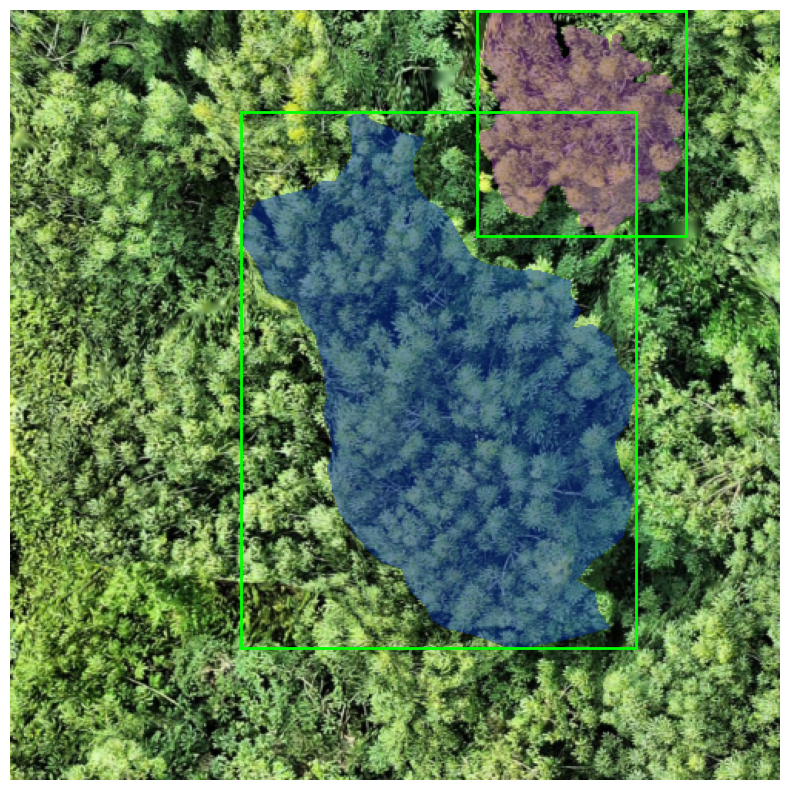

In [9]:
visualize_instance(train_set[40])

In [10]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [11]:
class PredictionProcessor:
    def __init__(self, mask_threshold=0.5, score_threshold=0.5):
        self.mask_threshold = mask_threshold
        self.score_threshold = score_threshold

    def __call__(self, prediction):
        # Handle empty predictions
        if not prediction or "masks" not in prediction or "scores" not in prediction:
            return {
                "boxes": torch.empty((0, 4)),
                "labels": torch.empty((0,), dtype=torch.int64),
                "scores": torch.empty((0,)),
                "masks": torch.empty((0, 1, 1, 1))
            }

        keep = prediction["scores"] >= self.score_threshold
        prediction = {k: v[keep] for k, v in prediction.items()}

        if "masks" in prediction and len(prediction["masks"]) > 0:
            prediction["masks"] = (prediction["masks"] > self.mask_threshold).float()

        return prediction

In [12]:
class LitMaskRCNN(pl.LightningModule):
    def __init__(self, lr=1e-3, num_classes=2, mask_threshold=0.5, score_threshold=0.5):
        super().__init__()
        self.save_hyperparameters()

        # Load pretrained Mask R-CNN with ResNet50 FPN backbone
        self.model = torchvision.models.detection.maskrcnn_resnet50_fpn(
            weights="DEFAULT"
        )

        # Replace box predictor head
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = \
            torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
                in_features, num_classes
            )

        # Replace mask predictor head
        in_features_mask = self.model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256
        self.model.roi_heads.mask_predictor = \
            torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
                in_features_mask, hidden_layer, num_classes
            )

        # Metric
        self.metric = MeanAveragePrecision()

        # Prediction post-processor
        self.pred_processor = PredictionProcessor(
            mask_threshold=mask_threshold,
            score_threshold=score_threshold
        )

    def forward(self, images, targets=None):
        return self.model(images, targets)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        loss_dict = self.model(images, targets)
        total_loss = sum(loss for loss in loss_dict.values())
        self.log("train_loss", total_loss, prog_bar=True, on_step=True, on_epoch=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        preds = self.model(images)

        preds_proc = [self.pred_processor(p) for p in preds]   # list of dicts
        targets_proc = list(targets)  # already a sequence, just make sure it's a list

        # update metric
        self.metric.update(preds_proc, targets_proc)

        # optional visualization
        if batch_idx == 0 and len(preds_proc) > 0:
            fig = visualize_instance((images[0], preds_proc[0]))
            self.logger.experiment.log({"val_sample": wandb.Image(fig)})
            plt.close(fig)

    def on_validation_epoch_end(self):
        metrics = self.metric.compute()
        self.log("val_mAP", metrics["map"], prog_bar=True)
        self.metric.reset()

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        images, _ = batch
        preds = self.model(images)
        preds_proc = self.pred_processor(preds)
        return preds_proc

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)

    def log_images(self, images, preds, tag="samples"):
        """
        Logs a single sample (image + prediction) to W&B.
        """
        if len(preds) == 0 or "masks" not in preds[0] or "scores" not in preds[0]:
            return
        x, p = images[0], preds[0]

        fig = visualize_instance((x, p))  # <-- matches your function signature
        self.logger.experiment.log({tag: wandb.Image(fig)})
        plt.close(fig)

In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))


tools.set_seed(42)
batch_size = 8
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size, collate_fn=collate_fn)
val_loader = DataLoader(val_set, shuffle=False, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size, collate_fn=collate_fn)

In [15]:
model = LitMaskRCNN(lr=1e-3, num_classes=2)

In [16]:
model.load_state_dict(torch.load("./mask_rcnn/instance_model_latest.pth"))

<All keys matched successfully>

In [17]:
pp = PredictionProcessor(mask_threshold=0.7, score_threshold=0.35)

In [18]:
wandb.init(project="intreeligent-maskrcnn", name="detectron2-infer-test")
wandb_logger = WandbLogger(
    save_dir="./wandb_logs",
    log_model='all'
)

wandb: Currently logged in as: juanico-hernel064 (juanico-hernel064-university-of-science-and-technology-o) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [35]:
model.eval()
with torch.no_grad():
    for batch in test_loader:
        xb, yb = batch
        pred = model(xb)
        for xidx, yidx in zip(xb, pred):
            fig = visualize_instance((xidx, pp(yidx)))
            wandb.log({'test_set': wandb.Image(fig)})
            fig